In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.layers import Dropout,BatchNormalization,LSTM,Bidirectional,GlobalMaxPool1D,Input,Activation,Flatten,Embedding,Dense,concatenate,Conv1D,MaxPooling1D
import string
import re
from tqdm import tqdm
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score,recall_score,precision_score,classification_report
import os
from keras.models import Model
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')
import tensorboard
from textblob import TextBlob
import os
import tensorboard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import datetime
from keras.initializers import he_normal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
data=pd.read_csv("../input/sarcasm/train-balanced-sarcasm.csv",nrows=300000)
data.shape

In [ ]:
data.head(5)

## Data Cleaning

label 1 is sarcastic and label 0 is not sarcastic

Counting the null values

In [ ]:
null_values=data.isna().sum()
print(null_values)

The comment column has 53 null values.We have dropped that values

In [ ]:
data=data.dropna()
data.isna().sum()

Checking duplicate values

In [ ]:
duplicate_values=data[data.duplicated()]
print("duplicate rows in the dataset",len(duplicate_values))
data.drop_duplicates(keep='first',inplace=True)

We can see that the score column has some erroneous values.

The score column is calculated as:Score=number of upvotes(ups)-number of downvotes(down)

In [ ]:
data['score']=data['ups']-data['downs']

## Exploratory Data Analysis

In [ ]:
counts=data['label']
sns.countplot(x=counts)
plt.show()

We can see that our dataset is balanced as it has almost equal number of class labels

In [ ]:
data.head(5)

In [ ]:
data.shape

## Preprocessing text data for EDA

In [ ]:
# slangs
strings='''AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
QPSA?=Que Pasa?
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher'''

In [ ]:
x1=strings.split("\n")
dict1={}
for i in x1:
    x2=(i.split("="))
    dict1[x2[0]]=x2[1]
print(dict1)

In [ ]:
def chat(text):
    new_text=[]
    for word in text.split():
        if word.upper() in dict1:
            new_text.append(dict1[word.upper()])
        else:
            new_text.append(word)
            
    done=" ".join(new_text)

            
    return done
            

In [ ]:
data['comment']=data['comment'].apply(chat)

In [ ]:
#decontract words
def decontracted(phrase):
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [ ]:
data['comment']=data['comment'].apply(decontracted)

In [ ]:
# lower case
data['comment']=data['comment'].str.lower()

In [ ]:
# removing stopwords

# we have removed stopwords like no,not,nor.
stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", 
            "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", 
            "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", 
            "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
            "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but",
            "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", 
            "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", 
            "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", 
            "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few",
            "more", "most", "other", "some", "such" "only", "own", "same", "so", "than", "too", "very", 
            "s", "t", "can", "will", "just", "don", "should", "now"]

In [ ]:
def stopwords1(text):
    new_list=[]
    for word in text.split():
        if word in stop_words:
            new_list.append("")
        else:
            new_list.append(word)

    done=list(filter(None,new_list))
    done=" ".join(done)
    
    return done

In [ ]:
data['comment']=data['comment'].apply(stopwords1)

In [ ]:
# remove html tags
def remove_html(text):
    return re.sub(r'<.*?>',"",text)

In [ ]:
data['comment']=data['comment'].apply(remove_html)

In [ ]:
# removing digits
def remove_numbers(text):
    return re.sub("\d+", "", text)
      

In [ ]:
data['comment']=data['comment'].apply(remove_numbers)

We haven't removed exclamation mark and question mark as sarcastic comments has exclamation mark in them

In [ ]:
string1=string.punctuation
string1=list(string1)
string1.remove('!')
string1.remove('?')
print(string1)

In [ ]:
def remove_punctuation(data):
    for char in string1:
        if char in data:
            data=data.replace(char," ")
    return data

In [ ]:
data['comment']=data['comment'].apply(remove_punctuation)

## Converting dataframes according to class label

In [ ]:
data_sarcasm=data[data['label']==1]
data_non_sarcasm=data[data['label']==0]

print((data_sarcasm.shape),data_non_sarcasm.shape)

Authors

Some authors have a definite style of writing. We call it as stylometric and personality feature.

The idea here is if sarcastic commments can be judged by the nature of individual.

We will see what set of people have written most sarcastic comments.

In [ ]:
author_counts_sarcasm=data_sarcasm['author'].value_counts()[:20]
plt.figure(figsize=(6,6))
sns.barplot(x=author_counts_sarcasm,y=author_counts_sarcasm.index,data=data_sarcasm)
plt.show()

In [ ]:
author_counts_non_sarcasm=data_non_sarcasm['author'].value_counts()[:20]
plt.figure(figsize=(6,6))
sns.barplot(x=author_counts_non_sarcasm,y=author_counts_non_sarcasm.index,data=data_non_sarcasm)
plt.show()

We can see that for both the labels the writer is almost same.


Subreddit

In [ ]:
subreddidt_sarcasm=data_sarcasm['subreddit'].value_counts()[:20]
plt.figure(figsize=(6,6))
sns.barplot(x=subreddidt_sarcasm,y=subreddidt_sarcasm.index,data=data_sarcasm)
plt.show()

In [ ]:
subreddidt_non_sarcasm=data_non_sarcasm['subreddit'].value_counts()[:20]
plt.figure(figsize=(6,6))
sns.barplot(x=subreddidt_non_sarcasm,y=subreddidt_non_sarcasm.index,data=data_non_sarcasm)
plt.show()

From above cells we can see that the topics for which sarcastic and non sarcastic comments are made are almost for same topics.

The politics category got the most sarcastic and non sarcastic comments.

In [ ]:
words=""
for sentence in data_sarcasm['comment']:
    tokens=(sentence.split())
    for i in range(len(tokens)):
        tokens[i]=tokens[i].lower()
    words +=" ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(words)

    # plot the WordCloud image                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


In [ ]:
words=""
for sentence in data_non_sarcasm['comment']:
    tokens=(sentence.split())
    for i in range(len(tokens)):
        tokens[i]=tokens[i].lower()
    words +=" ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(words)

    # plot the WordCloud image                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

From the above word cloud we can say that the words like(not,no,would,yeah etc) appears in both sarcastic and non sarcastic comments.

Average word length

In [ ]:
def average_word_length(text):
    list2=[]
    for sentence in text:
        count=len(sentence)
        list2.append(count)
    avg_word_length=sum(list2)/len(text)
    
    return avg_word_length
    

In [ ]:
print("average word length of sarcastic comments is",average_word_length(data_sarcasm['comment']))
print("average word length of non sarcastic comments is",average_word_length(data_non_sarcasm['comment']))

There is no diiference in average word length pf sarcastic and non sarcastic comments

Average sentence length

In [ ]:
def average_senetnce_length(text):
    sum1=0
    for sentence in text:
        count=len(sentence.split())
        sum1=sum1+count
        
    return (sum1/len(text))

In [ ]:
print("average word length of sarcastic comments is",average_senetnce_length(data_sarcasm['comment']))
print("average word length of non sarcastic comments is",average_senetnce_length(data_non_sarcasm['comment']))

There is no difference in between sentence length of sarcastic and non sarcastic comments

In [ ]:
def frequent_top_words(dataframe):
    top_words=20
    frequent_words=dataframe.str.cat(sep="")
    words=nltk.word_tokenize(frequent_words)
    frequency_disb=nltk.FreqDist(words)
    
    return frequency_disb.most_common(top_words)
    

In [ ]:
freq_sarcasm=frequent_top_words(data_sarcasm['comment'])
list1,list2=[],[]
for i,j in (freq_sarcasm):
    list1.append(i)
    list2.append(j)

plt.figure(figsize=(8,6))
sns.barplot(y=list1,x=list2)
plt.show()

In [ ]:
freq_non_sarcasm=frequent_top_words(data_non_sarcasm['comment'])
list1,list2=[],[]
for i,j in (freq_non_sarcasm):
    list1.append(i)
    list2.append(j)

plt.figure(figsize=(8,6))
sns.barplot(y=list1,x=list2)
plt.show()

The top 20 words are somewhat same for both sarcastic and non sarcastic comments

In [ ]:
def count_exclamation(text):
    sum1=0
    for i in text:
        if '!' in i:
            sum1=sum1+1
    return sum1

In [ ]:
print("number of sarcasm_exclamation is",count_exclamation(data_sarcasm['comment']))
print("number of non_sarcasm_exclamation is",count_exclamation(data_non_sarcasm['comment']))

We can see there is vast difference in exclamation mark in sarcastic and non sarcastic comments.

Exclamation mark can be a good feature for differntiating between sarcastic and non sarcastic comments.

In [ ]:
def count_question(text):
    sum1=0
    for i in text:
        if '?' in i:
            sum1=sum1+1
    return sum1

In [ ]:
print("number of sarcasm_question is",count_question(data_sarcasm['comment']))
print("number of non_sarcasm_question is",count_question(data_non_sarcasm['comment']))

We can see there is small difference in question mark in sarcastic and non sarcastic comments.

Question mark can be a feature for differntiating between sarcastic and non sarcastic comments.

## Univariate Analysis

Score column analysis

In [ ]:
# code taken from the iris EDA

sns.FacetGrid(data, hue="label", size=5) \
   .map(sns.distplot, "score") \
   .add_legend();
plt.show();

We can see that score are overlapping for both sarcastic and non sarcastic comments.

We can see that scores are 0 for most of the datapoints in both labels.

Upvote column analaysis

In [ ]:
sns.FacetGrid(data, hue="label", size=5) \
   .map(sns.distplot, "ups") \
   .add_legend();
plt.show()

We can see that upvotes for sarcastic is 4000 and for non sarcastic it is 5000

Most of the upvotes are overlapping to each other

Downvote column analysis

In [ ]:
sns.FacetGrid(data, hue="label", size=5) \
   .map(sns.distplot, "downs") \
   .add_legend();
plt.show();

We can see that there is some negative value for both class labels.It means people have downvoted comment they don't like.

There is overlapping for both sarcastic comments and non sarcastic comments.

## Basic Modelling

In [ ]:
data_basic=data.drop(['author','score','ups','downs','date','created_utc','parent_comment','subreddit'],axis=1)
# data_basic['exclamation_mark']=data_exclamation
# data_basic['question_mark']=data_question_mark

In [ ]:
y=data_basic['label']
X=data_basic.drop(['label'],axis=1)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=42,test_size=0.3,shuffle=True)
print((X_train.shape),y_train.shape)
print((X_test.shape),y_test.shape)

In [ ]:
# training dataset

In [ ]:
tokenizer=Tokenizer(num_words=40000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',oov_token='<OOV>')
tokenizer.fit_on_texts(list(X_train['comment']))
x_train=tokenizer.texts_to_sequences(X_train['comment'])
maxlen = 100
print(maxlen)
word_index=tokenizer.word_index
print(len(word_index)+1)

padded_sequences_train=pad_sequences(x_train,maxlen=maxlen,padding='post',truncating='post')

In [ ]:
# testing dataset

x_test=tokenizer.texts_to_sequences(X_test['comment'])
padded_sequences_test=pad_sequences(x_test,maxlen=maxlen,padding='post',truncating='post')

In [ ]:
print((padded_sequences_train.shape),padded_sequences_test.shape)

In [ ]:
path_to_glove_file = r'../input/facebook/crawl-300d-2M.vec'

# https://keras.io/examples/nlp/pretrained_word_embeddings/

embeddings_index = {}
with open(path_to_glove_file,encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
        
        
print("Found %s word vectors." % len(embeddings_index))

In [ ]:
num_tokens = len(tokenizer.word_index)+1
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

In [ ]:
print(embedding_matrix.shape)

vocab_size=len(tokenizer.word_index)+1
print(vocab_size)

## Basic Model 1

In [ ]:
from keras.initializers import he_normal
from tensorflow.keras.optimizers import Adam

In [ ]:
input_layer=Input(shape=(maxlen))
embedding_layer=Embedding(input_dim=vocab_size, output_dim=300,weights=[embedding_matrix],trainable=False)(input_layer)
lstm_layer=Bidirectional(LSTM(64,return_sequences=True))(embedding_layer)
drop=Dropout(0.4)(lstm_layer)
lstm_layer1=Bidirectional(LSTM(64,return_sequences=True))(drop)
drop2=Dropout(0.4)(lstm_layer1)
flatten_layer=Flatten()(drop2)
dense_layer1=Dense(256,activation='relu',kernel_initializer=he_normal())(flatten_layer)
drop3=Dropout(0.4)(dense_layer1)
flatten_layer1=Flatten()(drop3)
dense_layer3=Dense(32,activation='relu',kernel_initializer=he_normal())(flatten_layer1)
output_layer=Dense(1,activation='sigmoid')(dense_layer3)

model=Model(input_layer,output_layer)

model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
model.summary()

In [ ]:
print(padded_sequences_train.shape)
print(padded_sequences_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)



In [ ]:
earlystop=EarlyStopping(monitor='val_loss',verbose=1,patience=3,min_delta=0.35)

model.fit(padded_sequences_train,y_train,epochs=15,verbose=1,batch_size=512,
         validation_data=(padded_sequences_test,y_test),callbacks=[earlystop])

## Feature Enginnering

In [ ]:
def profanity_words(text):
    list1=[]
    for sentence in tqdm(text):
        profane_word=profanity.contains_profanity(sentence)
        list1.append(profane_word)
        
    return list1

In [ ]:
data_profanity_words=profanity_words(data['comment'])
# 100%|██████████| 1010745/1010745 [5:13:11<00:00, 53.79it/s]

In [ ]:
data_profane=pd.DataFrame(data_profanity_words)
data_profane.to_csv('data_profaned.csv')

In [ ]:
def sentiment_subjectivity(text):
    list1=[]
    for sentence in tqdm(text):
        subjectivity=TextBlob(sentence).sentiment.subjectivity
        list1.append(subjectivity)
    return list1

In [ ]:
data_sentiment_subj=(sentiment_subjectivity(data['comment']))

In [ ]:
data_senti=pd.DataFrame(data_sentiment_subj)
data_senti.to_csv('data_sentiment_subj.csv')

In [ ]:
def sentiment_intensity(text):
    neg_list,pos_list,neutral_list=[],[],[]
    for sentence in tqdm(text):
        sentiment_object= SentimentIntensityAnalyzer()
        polarity_scores=sentiment_object.polarity_scores(sentence)
        
        neg_list.append(polarity_scores['neg'])
        pos_list.append(polarity_scores['pos'])
        neutral_list.append(polarity_scores['neu'])
        
    return neg_list,pos_list,neutral_list
        
    

In [ ]:
data_pos,data_neg,data_neu=sentiment_intensity(data['comment'])

In [ ]:
# data_positive=pd.DataFrame(data_pos)
# data_positive.to_csv('data_positive.csv')

# data_negative=pd.DataFrame(data_neg)
# data_negative.to_csv('data_neagtive.csv')

# data_neutral=pd.DataFrame(data_neu)
# data_neutral.to_csv('data_neutral.csv')

In [ ]:
## Exclamation mark

def count_exclamation(text):
    list1=[]
    for i in text:
        if '!' in i:
            list1.append(1)
        else:
            list1.append(0)
            
    return list1

In [ ]:
data_exclamation=count_exclamation(data['comment'])

In [ ]:
## question mark

def count_question(text):
    list1=[]
    for i in text:
        if '?' in i:
            list1.append(1)
        else:
            list1.append(0)
            
    return list1

In [ ]:
data_question_mark=count_question(data['comment'])

In [ ]:
author_dict={}
author_names=list(data['author'].unique())
print(author_names[0:6])

In [ ]:
for i in tqdm(author_names):
    mask=data['author']==i
    string1=(data[mask].comment)
    string1="".join(string1)
    author_dict[i]=string1


In [ ]:
author_dictionary_strings=pd.Series(author_dict).to_frame()

In [ ]:
author_dictionary_strings.to_csv('author_dictionary.csv')

In [ ]:
data.head(3)

In [ ]:
# d1=pd.read_csv('data_sentiment_subj.csv')
# d2=d1.drop(['Unnamed: 0'],axis=1)
# d2
# d1=pd.read_csv('data_positive.csv')
# d2=d1.drop(['Unnamed: 0'],axis=1)
# d2

# d1=pd.read_csv('data_neagtive.csv')
# d2=d1.drop(['Unnamed: 0'],axis=1)
# d2

d1=pd.read_csv('data_neutral.csv')
d2=d1.drop(['Unnamed: 0'],axis=1)
d2

In [ ]:
# data_prep=data.drop(['author','score','ups','downs','date','created_utc','parent_comment','subreddit'],axis=1)
# data_prep['exclamation_mark']=data_exclamation
# data_prep['question_mark']=data_question_mark
# data_prep['sentiment_subjectivity']=d2
# data_prep['sentiment_positive']=d2
# data_prep['sentiment_negative']=d2
data_prep['sentiment_neutral']=d2

In [2]:
data_new=pd.read_csv('../input/data-pre3/data_preprocessed.csv')
data_new1=data_new.drop(['Unnamed: 0'],axis=1)
data_new1=data_new1.dropna()
data_new1.isna().sum()

label                     0
comment                   0
exclamation_mark          0
question_mark             0
sentiment_subjectivity    0
sentiment_positive        0
sentiment_negative        0
sentiment_neutral         0
profane_words             0
dtype: int64

In [3]:
data_new1.shape

(1008527, 9)

In [4]:
y=data_new1['label']
X=data_new1.drop(['label'],axis=1)

In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=42,test_size=0.3,shuffle=True)
print((X_train.shape),y_train.shape)
print((X_test.shape),y_test.shape)

(705968, 8) (705968,)
(302559, 8) (302559,)


In [6]:
sentiment_subj=X_train[ 'sentiment_subjectivity'].values
sentiment_neg=X_train[ 'sentiment_negative'].values
sentiment_pos=X_train[ 'sentiment_positive'].values
sentiment_neu=X_train[ 'sentiment_neutral'].values
exc_mark=X_train[ 'exclamation_mark'].values
ques_mark=X_train['question_mark'].values
profane_words=X_train['profane_words'].values

In [7]:
sentiment_subj_test=X_test[ 'sentiment_subjectivity'].values
sentiment_neg_test=X_test[ 'sentiment_negative'].values
sentiment_pos_test=X_test[ 'sentiment_positive'].values
sentiment_neu_test=X_test[ 'sentiment_neutral'].values
exc_mark_test=X_test[ 'exclamation_mark'].values
ques_mark_test=X_test['question_mark'].values
profane_words_test=X_test['profane_words'].values

In [8]:
tokenizer=Tokenizer(num_words=40000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',oov_token='<OOV>')
tokenizer.fit_on_texts(list(X_train['comment']))
x_train=tokenizer.texts_to_sequences(X_train['comment'])
maxlen = 100
print(maxlen)
word_index=tokenizer.word_index
print(len(word_index)+1)

padded_sequences_train=pad_sequences(x_train,maxlen=maxlen,padding='post',truncating='post')

100
129724


In [9]:
x_test=tokenizer.texts_to_sequences(X_test['comment'])
padded_sequences_test=pad_sequences(x_test,maxlen=maxlen,padding='post',truncating='post')


print((padded_sequences_train.shape),padded_sequences_test.shape)

(705968, 100) (302559, 100)


In [10]:
path_to_glove_file = r'../input/fastext/crawl-300d-2M.vec'

# https://keras.io/examples/nlp/pretrained_word_embeddings/

embeddings_index = {}
with open(path_to_glove_file,encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
        
        
print("Found %s word vectors." % len(embeddings_index))

Found 1999996 word vectors.


In [13]:
total_words = 40000

In [14]:
num_tokens = total_words+1
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if i<num_tokens:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 38381 words (1619 misses)


In [15]:
print(embedding_matrix.shape)

vocab_size=len(tokenizer.word_index)+1
print(vocab_size)

(40001, 300)
129724


In [16]:
print(padded_sequences_train.shape)
print(padded_sequences_test.shape)
print(y_train.shape)
print(y_test.shape)

(705968, 100)
(302559, 100)
(705968,)
(302559,)


In [17]:
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)

In [ ]:
# train_final=[padded_sequences_train,sentiment_subj.reshape(-1,1),sentiment_neg.reshape(-1,1),sentiment_pos.reshape(-1,1),sentiment_neu.reshape(-1,1),exc_mark.reshape(-1,1),ques_mark.reshape(-1,1),profane_words.reshape(-1,1)]
# test_final=[padded_sequences_test,sentiment_subj_test.reshape(-1,1),sentiment_neg_test.reshape(-1,1),sentiment_pos_test.reshape(-1,1),sentiment_neu_test.reshape(-1,1),exc_mark_test.reshape(-1,1),ques_mark_test.reshape(-1,1),profane_words_test.reshape(-1,1)]

In [19]:
input_layer=Input(shape=(maxlen))
embedding_layer=Embedding(input_dim=num_tokens, output_dim=300,weights=[embedding_matrix],trainable=False)(input_layer)
lstm_layer=Bidirectional(LSTM(64,return_sequences=True))(embedding_layer)
drop=Dropout(0.4)(lstm_layer)
lstm_layer1=Bidirectional(LSTM(64,return_sequences=True))(drop)
drop2=Dropout(0.4)(lstm_layer1)
flatten_layer=Flatten()(drop2)
dense_layer1=Dense(256,activation='relu',kernel_initializer=he_normal())(flatten_layer)
drop3=Dropout(0.4)(dense_layer1)
flatten_layer1=Flatten()(drop3)
dense_layer3=Dense(32,activation='relu',kernel_initializer=he_normal())(flatten_layer1)
output_layer=Dense(1,activation='sigmoid')(dense_layer3)

model=Model(input_layer,output_layer)

model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
model.summary()

2022-07-26 10:32:04.341695: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 48001200 exceeds 10% of free system memory.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          12000300  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          186880    
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0     

In [21]:
from tensorflow.keras.models import load_model
# Save the model
model.save('.//model_cnn.h5')
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

history=model.fit(padded_sequences_train,y_train,epochs=9,verbose=1,batch_size=128,
         validation_data=(padded_sequences_test,y_test),callbacks=[tensorboard_callback])

2022-07-26 10:33:11.446011: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 48001200 exceeds 10% of free system memory.
2022-07-26 10:33:11.582537: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-26 10:33:11.582600: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-07-26 10:33:12.217390: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-26 10:33:12.217571: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-07-26 10:33:12.364858: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 282387200 exceeds 10% of free system memory.
2022-07-26 10:33:12.473651: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/9


2022-07-26 10:33:17.524190: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


   1/5516 [..............................] - ETA: 8:58:24 - loss: 0.6937 - accuracy: 0.5391

2022-07-26 10:33:18.555444: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-26 10:33:18.555492: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/5516 [..............................] - ETA: 1:42:34 - loss: 0.6946 - accuracy: 0.4648

2022-07-26 10:33:19.477165: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-26 10:33:19.479502: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-07-26 10:33:19.644735: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2392 callback api events and 2389 activity events. 


   3/5516 [..............................] - ETA: 1:09:00 - loss: 0.6937 - accuracy: 0.4974

2022-07-26 10:33:19.679118: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-26 10:33:19.739774: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20220726-103311/train/plugins/profile/2022_07_26_10_33_19

2022-07-26 10:33:19.769808: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/20220726-103311/train/plugins/profile/2022_07_26_10_33_19/27271f44763b.trace.json.gz
2022-07-26 10:33:19.813485: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20220726-103311/train/plugins/profile/2022_07_26_10_33_19

2022-07-26 10:33:19.817892: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/20220726-103311/train/plugins/profile/2022_07_26_10_33_19/27271f44763b.memory_profile.json.gz
2022-07-26 10:33:19.821998: I tensorflow/core/profiler/rpc/client/capture_profile.

5516/5516 [==============================] - ETA: 0s - loss: 0.6180 - accuracy: 0.6536

2022-07-26 10:35:49.871636: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 121023600 exceeds 10% of free system memory.


5516/5516 [==============================] - 186s 33ms/step - loss: 0.6180 - accuracy: 0.6536 - val_loss: 0.5994 - val_accuracy: 0.6727
Epoch 2/9
5516/5516 [==============================] - 191s 35ms/step - loss: 0.5913 - accuracy: 0.6802 - val_loss: 0.5828 - val_accuracy: 0.6866
Epoch 3/9
5516/5516 [==============================] - 191s 35ms/step - loss: 0.5796 - accuracy: 0.6912 - val_loss: 0.5777 - val_accuracy: 0.6902
Epoch 4/9
5516/5516 [==============================] - 192s 35ms/step - loss: 0.5727 - accuracy: 0.6973 - val_loss: 0.5727 - val_accuracy: 0.6950
Epoch 5/9
5516/5516 [==============================] - 192s 35ms/step - loss: 0.5673 - accuracy: 0.7011 - val_loss: 0.5704 - val_accuracy: 0.6968
Epoch 6/9
5516/5516 [==============================] - 193s 35ms/step - loss: 0.5632 - accuracy: 0.7049 - val_loss: 0.5690 - val_accuracy: 0.6990
Epoch 7/9
5516/5516 [==============================] - 179s 32ms/step - loss: 0.5593 - accuracy: 0.7078 - val_loss: 0.5698 - val_accur

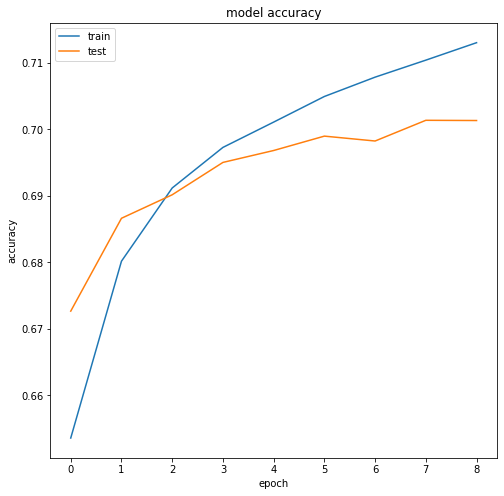

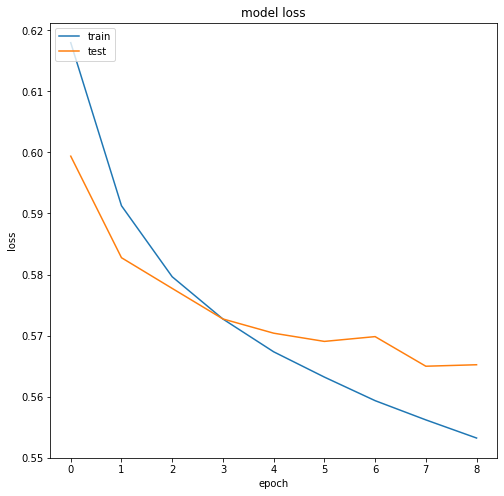

In [22]:
# machine learning mastery
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
y_pred=model.predict(padded_sequences_test)


print(y_test)
print(len(y_test))

[1 0 1 ... 1 1 1]
302559


In [25]:
print(y_pred)

result=list(map(lambda x:1 if x>=0.5 else 0,y_pred))
print(len(result))

[[0.9330794 ]
 [0.4285172 ]
 [0.2915287 ]
 ...
 [0.77725536]
 [0.74437624]
 [0.30497015]]
302559


In [26]:
cf_matrix=(confusion_matrix(y_test,result))

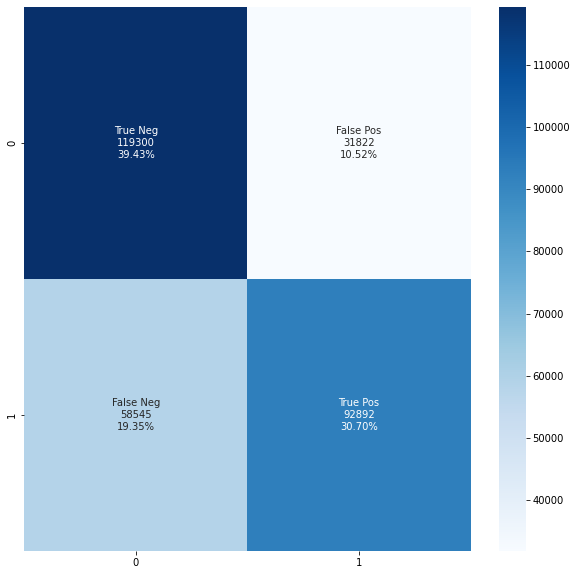

In [27]:
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
plt.figure(figsize=(10,10))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show()

In [28]:
print(classification_report(y_test,result))

              precision    recall  f1-score   support

           0       0.67      0.79      0.73    151122
           1       0.74      0.61      0.67    151437

    accuracy                           0.70    302559
   macro avg       0.71      0.70      0.70    302559
weighted avg       0.71      0.70      0.70    302559



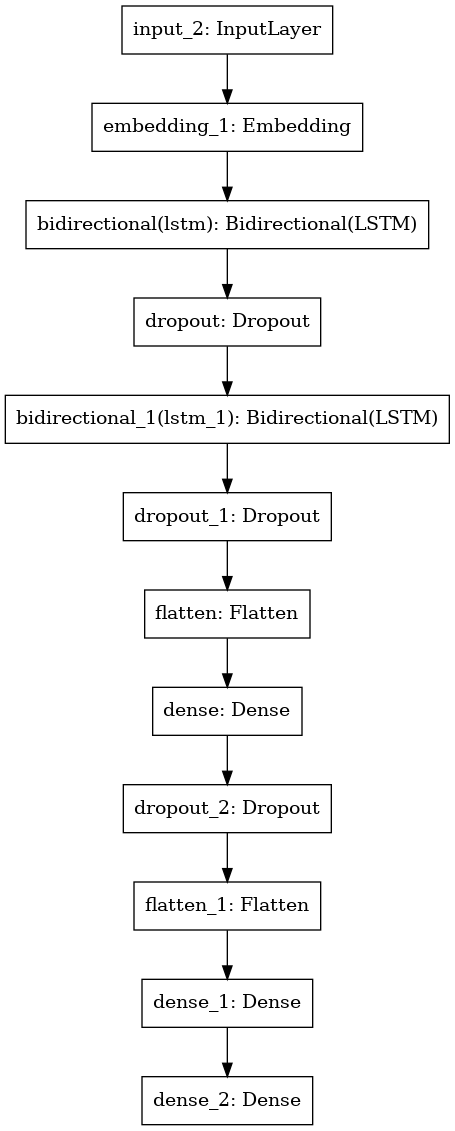

In [29]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
   
)